In [2]:
import matplotlib.pyplot as plt

In [3]:
import pandas as pd

# Load data from CSV file
file_path = "C:/Users/Welcome/Downloads/crude oil.csv"
data = pd.read_csv(file_path)

# Display the first few rows of the DataFrame
print(data.head())


  LOCATION INDICATOR SUBJECT MEASURE FREQUENCY  TIME  Value Flag Codes
0      AUS   OILPROD     TOT    KTOE         A  1960    NaN          L
1      AUS   OILPROD     TOT    KTOE         A  1961    NaN          L
2      AUS   OILPROD     TOT    KTOE         A  1962    NaN          L
3      AUS   OILPROD     TOT    KTOE         A  1963    NaN          L
4      AUS   OILPROD     TOT    KTOE         A  1964    NaN          L


In [7]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Filter data for Canada and Germany
canada_data = data[data['LOCATION'] == 'CAN']
germany_data = data[data['LOCATION'] == 'DEU']

# Preprocess the data
def preprocess_data(data):
    # Drop unnecessary columns
    data = data.drop(['LOCATION', 'INDICATOR', 'SUBJECT', 'MEASURE', 'FREQUENCY', 'Flag Codes'], axis=1)
    
    # Convert time column to datetime
    data['TIME'] = pd.to_datetime(data['TIME'], format='%Y')
    
    # Set TIME as index
    data.set_index('TIME', inplace=True)
    
    # Normalize the data and handle NaN values
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)
    data_scaled = np.nan_to_num(data_scaled)  # Replace NaN with 0
    
    return data_scaled, scaler

def create_sequences(data_scaled, look_back):
    X, y = [], []
    for i in range(len(data_scaled) - look_back):
        X.append(data_scaled[i:(i + look_back), 0])
        y.append(data_scaled[i + look_back, 0])
    return np.array(X), np.array(y)

def train_lstm_model(X_train, y_train, epochs=100, batch_size=32):
    # Reshape input data to be 3D [samples, timesteps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    
    # Build LSTM model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=50))
    model.add(Dense(units=1))
    
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
    
    loss = history.history['loss'][-1]  # Get the final training loss
    
    print("Final Training Loss:", loss)
    
    return model

def predict_future(model, data_scaled, scaler, look_back, future_steps):
    # Use the last 'look_back' data points to make predictions
    last_sequence = data_scaled[-look_back:]
    
    # Make predictions for future time steps
    predicted_values = []
    for i in range(future_steps):
        input_sequence = np.reshape(last_sequence, (1, look_back, 1))
        next_value = model.predict(input_sequence)
        last_sequence = np.append(last_sequence[1:], next_value, axis=0)
        predicted_values.append(next_value[0][0])
    
    # Inverse scale the predicted values
    predicted_values = scaler.inverse_transform(np.array(predicted_values).reshape(-1, 1))
    
    return predicted_values

# Preprocess data for Canada and Germany
canada_data_scaled, canada_scaler = preprocess_data(canada_data)
germany_data_scaled, germany_scaler = preprocess_data(germany_data)

# Choose the number of previous time steps to use for prediction
look_back = 3

# Create sequences for Canada and Germany data
X_canada, y_canada = create_sequences(canada_data_scaled, look_back)
X_germany, y_germany = create_sequences(germany_data_scaled, look_back)

# Train LSTM models for Canada and Germany
model_canada = train_lstm_model(X_canada, y_canada)
model_germany = train_lstm_model(X_germany, y_germany)

# Number of future time steps to predict
future_steps = 5

# Predict future values for Canada and Germany
predicted_values_canada = predict_future(model_canada, canada_data_scaled, canada_scaler, look_back, future_steps)
predicted_values_germany = predict_future(model_germany, germany_data_scaled, germany_scaler, look_back, future_steps)

# Print predicted values for Canada
print("Predicted values for Canada:")
for i, value in enumerate(predicted_values_canada, start=1):
    print(f"Year {i}: {value[0]}")

# Print predicted values for Germany
print("\nPredicted values for Germany:")
for i, value in enumerate(predicted_values_germany, start=1):
    print(f"Year {i}: {value[0]}")


Final Training Loss: 0.004404635168612003
Final Training Loss: 0.01772257871925831
1/1 [==============================] - 0s 23ms/step
Predicted values for Canada:
Year 1: 188258.875
Year 2: 202656.859375
Year 3: 223693.28125
Year 4: 249123.265625
Year 5: 281188.9375

Predicted values for Germany:
Year 1: 2573.212158203125
Year 2: 2759.492431640625
Year 3: 2905.376708984375
Year 4: 3008.997314453125
Year 5: 3085.16796875


In [70]:
# Create DataFrame for predicted values for Canada
predicted_years_canada = pd.date_range(start='2018', periods=future_steps, freq='Y')
predicted_data_canada_df = pd.DataFrame({'TIME': predicted_years_canada.year, 'Value': predicted_values_canada.flatten()})
predicted_data_canada_df.index += 1  # Start index from 1
predicted_data_canada_df.index.name = 'TIME'

# Create DataFrame for predicted values for Germany
predicted_years_germany = pd.date_range(start='2018', periods=future_steps, freq='Y')
predicted_data_germany_df = pd.DataFrame({'TIME': predicted_years_germany.year, 'Value': predicted_values_germany.flatten()})
predicted_data_germany_df.index += 1  # Start index from 1
predicted_data_germany_df.index.name = 'TIME'

# Print DataFrames
print("Predicted values for Canada:")
print(predicted_data_canada_df)

print("\nPredicted values for Germany:")
print(predicted_data_germany_df)

Predicted values for Canada:
      TIME          Value
TIME                     
1     2018  189900.859375
2     2019  203708.140625
3     2020  226170.312500
4     2021  253081.031250
5     2022  285185.062500

Predicted values for Germany:
      TIME        Value
TIME                   
1     2018  2711.746582
2     2019  2813.020264
3     2020  2942.772217
4     2021  3056.829102
5     2022  3135.512207


In [71]:
canada_data = data[data['LOCATION'] == 'CAN']
germany_data = data[data['LOCATION'] == 'DEU']

germany_data = germany_data[['TIME', 'Value']]
canada_data = canada_data[['TIME', 'Value']]

In [72]:
germany_extended = pd.concat([germany_data, predicted_data_germany_df], ignore_index=True)

canada_extended = pd.concat([canada_data, predicted_data_canada_df], ignore_index=True)


In [81]:
germany_extended

,TIME,Value
0,1960,NaN
1,1961,NaN
2,1962,NaN
3,1963,NaN
4,1964,NaN
...,...,...
58,2018,2711.746582
59,2019,2813.020264
60,2020,2942.772217
61,2021,3056.829102


In [80]:
pd.set_option('display.max_rows', 10)

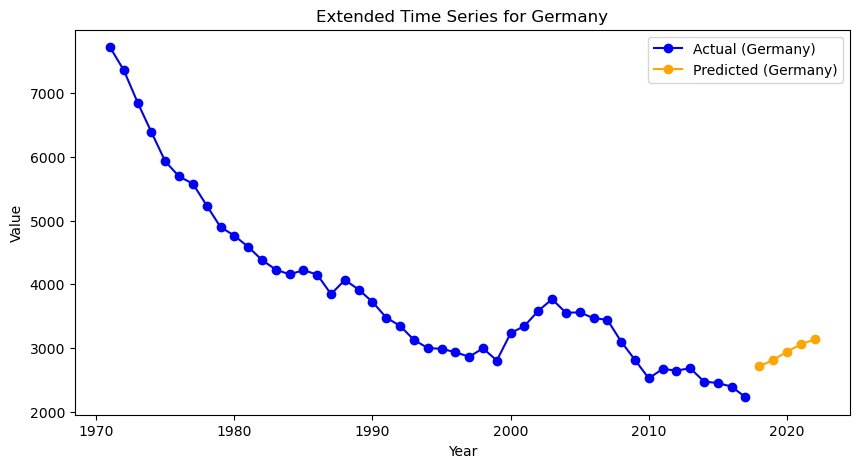

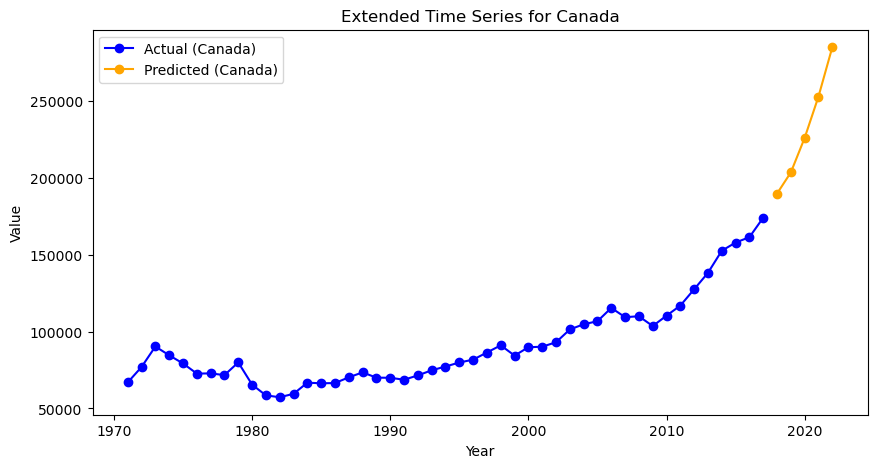

In [83]:
import matplotlib.pyplot as plt

# Plot extended time series for Germany
plt.figure(figsize=(10, 5))
plt.plot(germany_data['TIME'], germany_data['Value'], label='Actual (Germany)', color='blue', marker='o')
plt.plot(predicted_data_germany_df['TIME'], predicted_data_germany_df['Value'], label='Predicted (Germany)', color='orange', marker='o')
plt.title('Extended Time Series for Germany')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.show()

# Plot extended time series for Canada
plt.figure(figsize=(10, 5))
plt.plot(canada_data['TIME'], canada_data['Value'], label='Actual (Canada)', color='blue', marker='o')
plt.plot(predicted_data_canada_df['TIME'], predicted_data_canada_df['Value'], label='Predicted (Canada)', color='orange', marker='o')
plt.title('Extended Time Series for Canada')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.show()
